# The Transient Universe

In [1]:
import numpy as np
from scipy import stats, interpolate
import scipy.stats
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import optimize
plt.rcParams['figure.figsize'] = [4, 4]


from scipy.stats import cauchy
import emcee


#### Data Catalouge
We have access to a catalouge containing some time-series measurements from a transient phenomenon. It's shaped in an (100x3) array. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux.

In [2]:
x = np.load('../../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
d_flux = x[:,2]

#### Let's start by plotting the data 

Text(0.5, 1.0, 'Transient phenomenas')

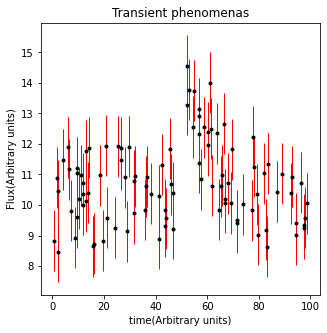

In [3]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, d_flux, fmt='.k', lw=1, ecolor='red')
ax.set_xlabel('time(Arbitrary units)')
ax.set_ylabel('Flux(Arbitrary units)')
ax.set_title('Transient phenomenas')

The data are homoscedastic

In [4]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

In [5]:
def model(t, x):
    b, A, to, alpha  = x
    return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

#likelihood assuming a gaussian flux[i] - model, product exp(-(f-model)^2/sigma^2)

In [6]:
#starting guess
t0_quick=50
A_quick=5
b_quick=10
alpha_quick=0.1


x_quick= np.array([b_quick,A_quick,t0_quick,alpha_quick])

In [7]:
def LogLikelihood(x, flux, d_flux ):
    y = model(time, x)
    #-0.5 * np.sum((y-y_fit)**2 / sigma_y**2 
    return -0.5*np.sum((flux-y)**2 / d_flux**2) 

def LogPrior(x):
    b,A,t0,alpha = x
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return 0.0 + 0.0 + 0.0 -np.log(alpha)
    else: 
        return -np.inf

def myLogPosterior(x, flux, d_flux):
    return LogLikelihood(x, flux, d_flux) + LogPrior(x)


### Now we procede using the module emcee

In [8]:
ndim = 4  # number of parameters in the model
nwalkers = 24  # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = x_quick + 1e-1* np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[flux, d_flux])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

C:\Users\LEONARDO\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


done


In [9]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(24, 100000, 4)
(2160000, 4)


In [10]:
print(emcee_trace)

[[10.32675654  5.2732372  49.32753083  0.11646348]
 [10.35695884  5.11998594 49.46816447  0.12658248]
 [10.39275516  5.83613129 48.42601147  0.13429456]
 ...
 [10.40454504  7.04946262 47.96463636  0.1291931 ]
 [10.33997745  6.11039695 47.73829588  0.11005548]
 [10.33997745  6.11039695 47.73829588  0.11005548]]


In [11]:
b = emcee_trace[:,0]
A = emcee_trace[:,1]
to = emcee_trace[:,2]
alpha = emcee_trace[:,3]
print(b)
print(A)
print(to)
print(alpha)


[10.32675654 10.35695884 10.39275516 ... 10.40454504 10.33997745
 10.33997745]
[5.2732372  5.11998594 5.83613129 ... 7.04946262 6.11039695 6.11039695]
[49.32753083 49.46816447 48.42601147 ... 47.96463636 47.73829588
 47.73829588]
[0.11646348 0.12658248 0.13429456 ... 0.1291931  0.11005548 0.11005548]


In [12]:
print(len(b))

2160000


## Trace plots

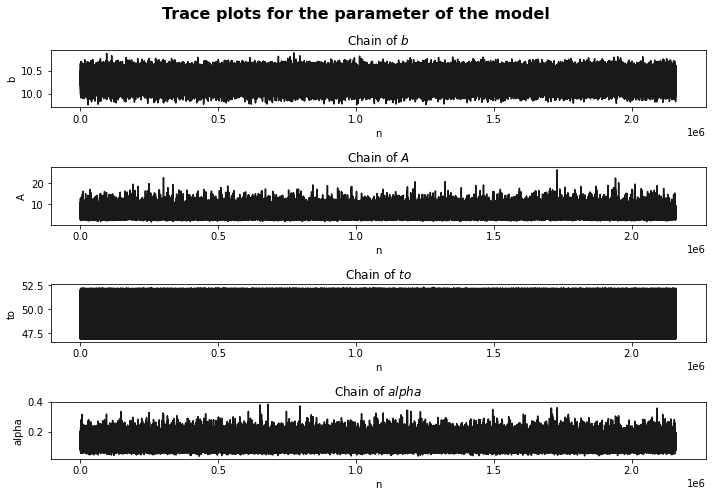

In [13]:
fig, ax= plt.subplots(4, figsize=(10, 7))#, sharex=True)
ax[0].plot(b, color='black', alpha = 0.9)
ax[1].plot(A, color='black', alpha = 0.9)
ax[2].plot(to, color='black', alpha = 0.9)
ax[3].plot(alpha, color='black', alpha = 0.9)

fig.suptitle('Trace plots for the parameter of the model', fontsize = 16, fontweight="bold")

ax[0].set_xlabel('n')
ax[0].set_ylabel('b')
ax[0].set_title('Chain of $b$')


ax[1].set_xlabel('n')
ax[1].set_ylabel('A')
ax[1].set_title('Chain of $A$')

ax[2].set_xlabel('n')
ax[2].set_ylabel('to')
ax[2].set_title('Chain of $to$')

ax[3].set_xlabel('n')
ax[3].set_ylabel('alpha')
ax[3].set_title('Chain of $alpha$')



fig.tight_layout()
plt.show()

## Now take one point every autocorrelation lenght

In [14]:
tau = sampler.get_autocorr_time()
print(tau)
thin = tau.astype(int) +1 
print(thin)

[59.75551364 81.77010018 78.82249301 67.18208801]
[60 82 79 68]


In [15]:
new_samples = sampler.get_chain(discard=int(burn/max(thin)), thin = max(thin), flat=True)
print(new_samples.shape)

(29232, 4)


In [16]:
print(new_samples[0])

[10.2930241   4.09956393 50.44652223  0.08425539]


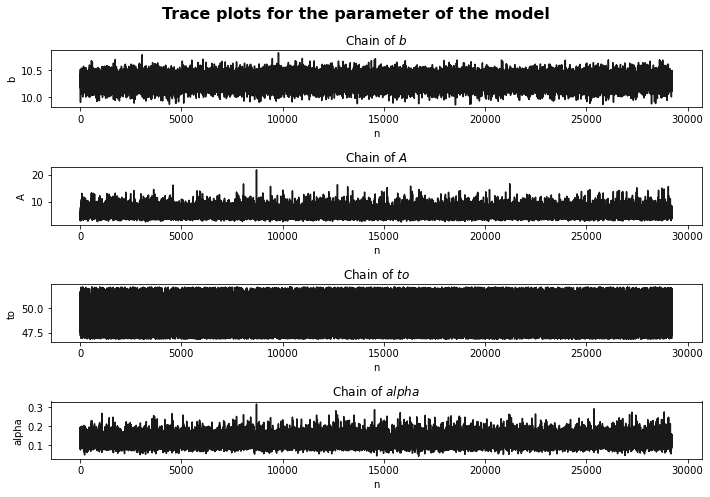

In [17]:
fig, ax= plt.subplots(4, figsize=(10, 7))#, sharex=True)
ax[0].plot(new_samples[:,0], color='black', alpha = 0.9)
ax[1].plot(new_samples[:,1], color='black', alpha = 0.9)
ax[2].plot(new_samples[:,2], color='black', alpha = 0.9)
ax[3].plot(new_samples[:,3], color='black', alpha = 0.9)

fig.suptitle('Trace plots for the parameter of the model', fontsize = 16, fontweight="bold")

ax[0].set_xlabel('n')
ax[0].set_ylabel('b')
ax[0].set_title('Chain of $b$')


ax[1].set_xlabel('n')
ax[1].set_ylabel('A')
ax[1].set_title('Chain of $A$')

ax[2].set_xlabel('n')
ax[2].set_ylabel('to')
ax[2].set_title('Chain of $to$')

ax[3].set_xlabel('n')
ax[3].set_ylabel('alpha')
ax[3].set_title('Chain of $alpha$')




fig.tight_layout()
plt.show()

### Let's realize the Corner plot of the 4-D parameter space.
#### We chose a credible levels of [68-95]%


Text(0.5, 1.04, 'Corner plot 4-D parameter space')

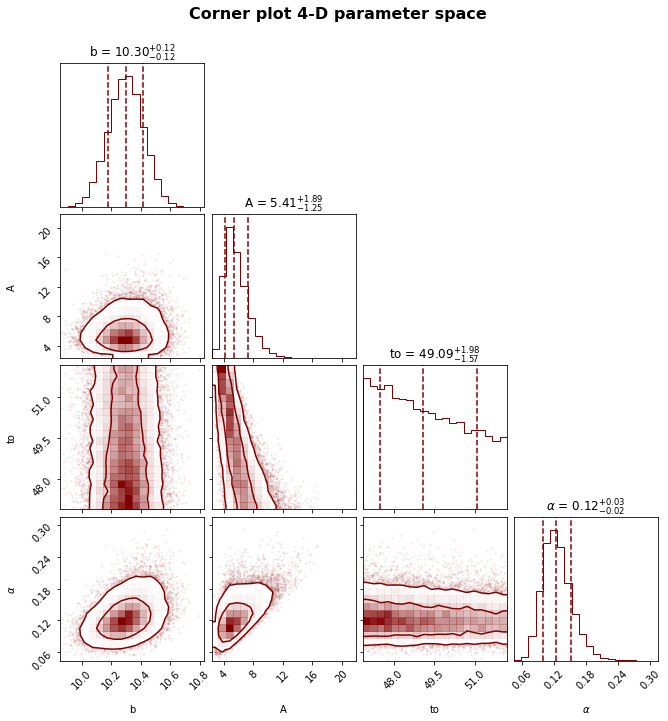

In [18]:
import corner

labels = ["b", "A", "to", r"$\alpha$"]
fig = corner.corner(new_samples, labels=labels, levels=[0.68,0.95], quantiles =[0.16,0.5,0.84], show_titles= True, color = 'maroon');
fig.suptitle('Corner plot 4-D parameter space', fontsize = 16, fontweight="bold",  y=1.04)

#### Now we choose 100 samples randomly from the burned, thinned chain and plot the 100 corresponding burst time-series on a figure along with the original data. 

Text(0.5, 1.04, 'Posterior spread of the model vs data')

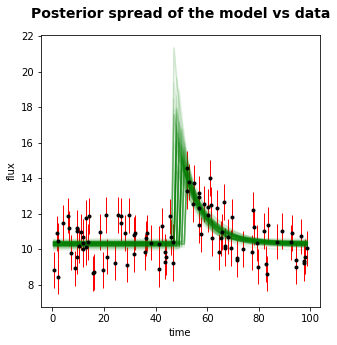

In [19]:
plt.rcParams['figure.figsize'] = [5, 5]
import random
random_samples = np.array(random.sample(new_samples.tolist(), k = 100))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, d_flux, fmt='.k', lw=1, ecolor='red')

xgrid = np.linspace(min(time), max(time), len(time))

[plt.plot(xgrid, model(xgrid, rs), color = 'green', alpha = 0.1) for rs in (random_samples)];
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Posterior spread of the model vs data',fontsize = 14, fontweight="bold",  y=1.04)

## Let's do some summary statistics

Let's find the median of each value

In [20]:
median = np.median(new_samples, axis = 0)
print(median)

[10.29767068  5.40973992 49.08834268  0.12254225]


We have to find the 90% credibility region

In [21]:
low, med, up = np.percentile(new_samples, [5, 50, 95], axis = 0)
print("5% percentile:", low)
print("50% percentile:", med)
print("95% percentile:", up)

5% percentile: [10.0980812   3.59452375 47.06159762  0.08576882]
50% percentile: [10.29767068  5.40973992 49.08834268  0.12254225]
95% percentile: [10.49494571  8.91100227 51.82419488  0.17700969]


In [22]:
labels = ["b","A","t0","alpha"]
for i,j in zip(np.arange(0,4,1), labels):
    print(j + ": " + str(round(median[i], 3)) + " + " + str(round((med[i]-low[i]), 3)) + " - "  + str(round((up[i]-med[i]),3)))

b: 10.298 + 0.2 - 0.197
A: 5.41 + 1.815 - 3.501
t0: 49.088 + 2.027 - 2.736
alpha: 0.123 + 0.037 - 0.054


### Warning about summary statistics
Each line is a posterior sample that correspondes to a single model, to get one model you can take the maximum a posteriori

Taking all the median it's not correct, these numbers don't correspond to a model, since they don't live in the four dimension space

We should pick the 4 "coupled" parameter that maximaze the posterior.

In [23]:
log_probabilities_mcmc = sampler.get_log_prob(discard=int(burn/max(thin)), thin = max(thin), flat=True)

max_posterior_idx = np.argmax(log_probabilities_mcmc)
max_posterior_mcmc = new_samples[max_posterior_idx]
print('Parameters that maximize the posterior: ', max_posterior_mcmc)

Parameters that maximize the posterior:  [10.27577829  6.19239514 47.82301356  0.11399911]
